# K-Nearest Neighbours 

In [1]:
import pandas as pd
import numpy as np
import os
import time
import math
import warnings # current version of seaborn generates a bunch of warnings that we'll ignore
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
from sil_coef import silhouette_coefficient
import random
random.seed(10)

warnings.filterwarnings("ignore")
sns.set(style="white", color_codes=True)
%matplotlib inline

def get_iris_data(file_name):
    """Simple function to pre-process the iris dataset."""

    # Specify column names and read in data
    i_names = ['s_len', 's_wid', 'p_len', 'p_wid', 'species']
    iris = pd.read_table(os.path.join(os.getcwd(), file_name), header=None, sep=',', names=i_names)

    return iris

In [2]:
df = get_iris_data('iris.data')
df.head()

,s_len,s_wid,p_len,p_wid,species
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


In [3]:
print("The data set contains {} records and {} features.".format(df.shape[0], df.shape[1]))

The data set contains 150 records and 5 features.


In [4]:
df['species'].value_counts()

Iris-versicolor    50
Iris-virginica     50
Iris-setosa        50
Name: species, dtype: int64

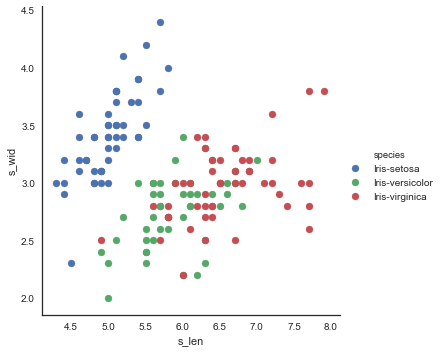

In [5]:
sns.FacetGrid(df, hue="species", size=5) \
   .map(plt.scatter, "s_len", "s_wid") \
   .add_legend()

We can also just look at one of the features to get a better sense of a feature's distribution.

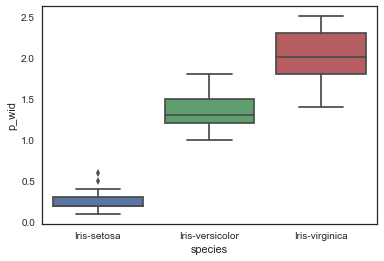

In [6]:
sns.boxplot(x="species", y="p_wid", data=df)

### Let's get down to business

Now we're *finally* going to implement our iterative refinement technique. 

At the highest level, here's the pseudocode to do so:

    Initialize centroids
    
    Enter loop
        
        Stash copy of old centroids
        Calculate distance from each data point to centroid
        Assign each data point to cluster with closest mean
        Calculate the new means of each cluster
        Update the centroids
        
    Continue until centroids converge
    
And the corresponding "code-code":

In [7]:
class KMeans:
    """The k-means algorithm."""

    def __init__(self, n_clusters):
        self.data = pd.DataFrame()
        self.n_clusters = n_clusters
        self.centroids = pd.DataFrame()
        self.clusters = np.ndarray(1)
        self.old_centroids = pd.DataFrame()
        self.verbose = False
        self.predictions = list()

    def train(self, df, verbose):
        self.verbose = verbose
        self.data = df.copy(deep=True)
        self.clusters = np.zeros(len(self.data))

        if 'species' in self.data.columns:
            self.data.drop('species', axis=1, inplace=True)

        # Randomly initialize centroids
        unique_rows = self.data.drop_duplicates()
        unique_rows.reset_index(drop=True, inplace=True)
        self.centroids = unique_rows.sample(n=self.n_clusters)
        self.centroids.reset_index(drop=True, inplace=True)

        if self.verbose:
            print("\nRandomly initiated centroids:")
            print(self.centroids)

        # Initialize old centroids as a matrix of all 0's
        self.old_centroids = pd.DataFrame(np.zeros(shape=(self.n_clusters, self.data.shape[1])),
                                          columns=self.data.columns)

        # Compare every data point in our dataset to each of the k-means and assign each point to closest cluster
        while not self.old_centroids.equals(self.centroids):
            
            if self.verbose:
                time.sleep(3)

            # Stash old centroids
            self.old_centroids = self.centroids.copy(deep=True)

            # Iterate through each data point in the matrix
            for row_i in range(0, len(self.data)):
                distances = list()
                point = self.data.iloc[row_i]

                # Calculate the distance between the current point and each of the centroids
                for row_c in range(0, len(self.centroids)):
                    centroid = self.centroids.iloc[row_c]
                    distances.append(np.linalg.norm(point - centroid))

                # Assign this data point to a cluster
                self.clusters[row_i] = np.argmin(distances)

            # For each cluster extract the values which now belong to each cluster and calculate new k-means
            for cls in range(0, self.n_clusters):

                cls_idx = np.where(self.clusters == cls)[0]

                if len(cls_idx) == 0:
                    self.centroids.loc[cls] = self.old_centroids.loc[cls]
                else:
                    # Set the new k-mean to the mean value of the data points within this cluster
                    self.centroids.loc[cls] = self.data.iloc[cls_idx].mean()
                    
                if self.verbose:
                    print("\nRow indices belonging to cluster {}: [n={}]".format(cls, len(cls_idx)))
                    print(cls_idx)

            if self.verbose:
                print("\nOld centroids:")
                print(self.old_centroids)
                print("New centroids:")
                print(self.centroids)

In [8]:
# Run through a simple application
number_of_clusters = 3
kmeans = KMeans(n_clusters=number_of_clusters)
kmeans.train(df=df, verbose=False)

In [9]:
# Extract the results
df['cluster'] = kmeans.clusters
centroids = kmeans.centroids
centroids['cluster'] = 'centroid'
all_df = pd.concat([df, centroids])

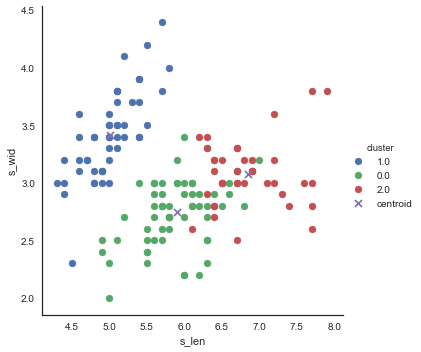

In [10]:
# Plot the cluster centroids
sns.FacetGrid(all_df, hue="cluster", size=5, hue_kws={"marker":["o", "o", "o", "x"]}).map(plt.scatter, "s_len", "s_wid").add_legend()

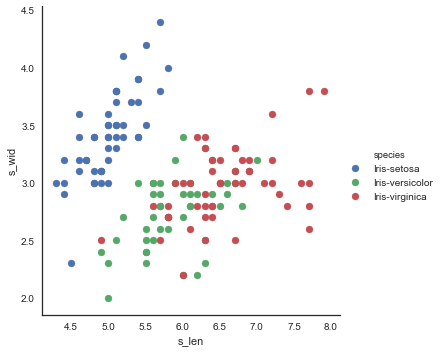

In [11]:
# Plot the clusters
sns.FacetGrid(all_df, hue="species", size=5).map(plt.scatter, "s_len", "s_wid").add_legend()

## Model evaluation

So we've implemented our algorithm - now what do we do with it?

How do we know that picking $ k = 2 $ is better than $ k = 5 $? How can we back that up with some proof?

We'll apply two evaluation methods called the **Elbow method** and the **Silhouette method** to help us decide.

Because we're working with an unsupervised method, evaluating can be fairly subjective. We have no "ground-truth" to compare to - so we can't exactly define how accurate our clustering results are. However, we can represent how similar data points are within the same cluster and how dissimilar data points are in different clusters. In other words, how well-separated is our data with respect to each cluster centroid?

The Elbow method calculates **distortion**, or the average minimum distance from each data point to a centroid. In other words, we go through each data point and record the distance between the data point and the closest centroid. Then, we average all these minimum distances. This gives us a sense of, on average, how close our data points are to a centroid.

The Silhouette method adds a little more flavor. We calculate the **silhouette** for each data point, which tells us how closely it is matched to data within its cluster and how loosely it is matched to data in the nearest cluster. We then average the silhouette for each of our data points. An average silhouette closer to 1 implies data points are in the appropriate cluster, while a silhouette close to -1 implies data points are in the wrong cluster.

For k=1	Avg. Sil. Coef: -1.0	Distortion: 1.9430341590370253
For k=2	Avg. Sil. Coef: 0.6936772807489379	Distortion: 0.8560279682448627
For k=3	Avg. Sil. Coef: 0.6116390494392429	Distortion: 0.6489747979610452
For k=4	Avg. Sil. Coef: 0.5524478357288615	Distortion: 0.6093560709416711
For k=5	Avg. Sil. Coef: 0.6103440875719183	Distortion: 0.5392488605309185


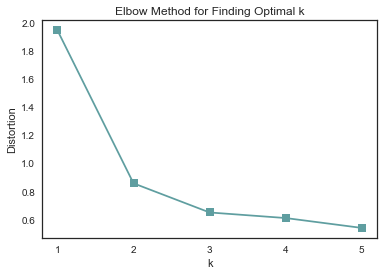

In [12]:
# Set up parameters
sil_coefs = list()
distortions = list()
K = [1, 2, 3, 4, 5]

# Test out multiple values for k
for k in K:
    kmeans = KMeans(n_clusters=k)
    kmeans.train(df=df, verbose=False)
    
    # Extract the results
    df['cluster'] = kmeans.clusters

    # Calculate silhouette coefficient
    s_c = silhouette_coefficient(df=df, clusters=kmeans.clusters, n_clusters=k)
    
    # Calculate distortion
    centroid_vals = kmeans.centroids[kmeans.centroids.columns[:-1]]
    d = df[df.columns[:-2]]
    distortion = sum(np.min(cdist(d, centroid_vals, 'euclidean'), axis=1)) / d.shape[0]
    
    print("For k={}\tAvg. Sil. Coef: {}\tDistortion: {}".format(k, s_c, distortion))
       
    # Keep track of cluster size metrics
    distortions.append(distortion)
    sil_coefs.append(s_c)
    
# Elbow plot
plt.plot(K, distortions, 's-', markersize=8, color='cadetblue', mec='gray')
plt.xlabel('k')
plt.xticks(K)
plt.ylabel('Distortion')
plt.title('Elbow Method for Finding Optimal k')
plt.show()

##  Comparison to a standard ML library

In [13]:
from sklearn.cluster import KMeans as sklKMeans
from sklearn import datasets

k = 2

# Re-load data set
iris = get_iris_data('iris.data')
kmeans = sklKMeans(n_clusters=k, init='random').fit(iris[iris.columns[:-1]].values)

# Calculate silhouette coefficient
s_c = silhouette_coefficient(df=iris, clusters=kmeans.labels_, n_clusters=k)

# Calculate distortion
distortion = sum(np.min(cdist(iris[iris.columns[:-1]], kmeans.cluster_centers_, 'euclidean'), axis=1)) / iris.shape[0]
print("For k={}\tAvg. Sil. Coef: {}\tDistortion: {}".format(k, s_c, distortion))

For k=2	Avg. Sil. Coef: 0.6808136202936815	Distortion: 0.8560279682448629
